In [0]:
%%capture
!pip install numpy
!pip install pandas==0.23.4
!pip install matplotlib
!pip install seaborn==0.9.0
!pip install missingno
!pip install beautifulsoup4
!pip install langid
!pip install xlrd 
!pip install spacy

In [5]:
import spacy.cli
#downloading language model for text processing
spacy.cli.download("en_core_web_md")


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [0]:
import warnings
warnings.filterwarnings(action='once')

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', -1)

In [8]:
#Change this if your are running local
filepath = 'data.xlsx'

raw = pd.read_excel(filepath, index_col='TweetID') 
raw.head()

,TweetPostedTime,TweetBody,TweetRetweetFlag,TweetSource,TweetInReplyToStatusID,TweetInReplyToUserID,TweetInReplyToScreenName,TweetRetweetCount,TweetFavoritesCount,TweetHashtags,TweetPlaceID,TweetPlaceName,TweetPlaceFullName,TweetCountry,TweetPlaceBoundingBox,TweetPlaceAttributes,TweetPlaceContainedWithin,UserID,UserName,UserScreenName,UserLocation,UserDescription,UserLink,UserExpandedLink,UserFollowersCount,UserFriendsCount,UserListedCount,UserSignupDate,UserTweetCount,MacroIterationNumber,tweet.place
TweetID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
811163485052817408,Tue Dec 20 10:57:00 +0000 2016,RT @BeachyMaldives: Local interaction is a great way to gain insight into the Maldivian way of life. #Maldives #vacation #travel https://t.…,True,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,1,0,"Maldives, vacation, travel",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3325724261,CjQenterprises,CjQenterprises,United States,Pls donate 2 https://t.co/RvOUK9lAWI #YearEndGiving. Creative ideas That Lift U Up! Award winnr. The Family Adventures of Princess Ladybug & Princess Ladybird .,https://t.co/jghZVBsiQF,http://cjqenterprises.com,6334,6144,1917,Sun Jun 14 22:36:15 +0000 2015,33556,0,NaN
811163483463122944,Tue Dec 20 10:56:59 +0000 2016,RT @TechTerraEd: Need #giftideas for your kid(s)? Read our Top 25 #holiday Gift Picks List. Share &amp; email us for a chance to win one! https…,True,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,1,0,"giftideas, holiday",NaN,NaN,NaN,NaN,NaN,NaN,NaN,101222953,monica,mama0004,durham nc,"Educator of students with special needs, Mother, Grandmother and undergrad student studying education. Teacher of technology to students and peers.",NaN,NaN,154,371,180,Sat Jan 02 13:36:23 +0000 2010,3201,0,NaN
811163466387988480,Tue Dec 20 10:56:55 +0000 2016,Seven Questions Before Choosing a Cruise Line #travel #TTOT https://t.co/0geOo7v5A4,False,"<a href=""http://www.google.com/"" rel=""nofollow"">Google</a>",NaN,NaN,NaN,0,0,"travel, TTOT",NaN,NaN,NaN,NaN,NaN,NaN,NaN,42725028,Paula Schuck,inkscrblr,Canada,"Thrifty Mom Media social media consulting and content development. One of Cision's 10 Most Influential Canadian Mom Bloggers. Travel, tech and health.",https://t.co/cEhGzaQJp6,http://www.thriftymommastips.com/,23433,24762,961,Tue May 26 21:26:09 +0000 2009,147958,0,NaN
811163465125679104,Tue Dec 20 10:56:55 +0000 2016,"RT @CMGsportsclub: Yoga do Brasil, un havre de paix à l’autre bout du monde https://t.co/h6UNf2tTsa #yoga #bresil #meditation #holiday",True,"<a href=""https://roundteam.co"" rel=""nofollow"">RoundTeam</a>",NaN,NaN,NaN,1,0,"yoga, bresil, meditation, holiday",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3541532718,Primal Sanctuary,primalsanctuary,"Cypress, Texas, USA","Adventure travel, yoga, paleo, Crossfit, running, gratitude, surfing, UltrAspire, WODies, OCR. https://t.co/3IHwXkgAkA",https://t.co/3IHwXkgAkA,https://primalsanctuary.com,11136,10081,978,Sat Sep 12 20:29:18 +0000 2015,28988,0,NaN
811163457508642817,Tue Dec 20 10:56:53 +0000 2016,"RT @StylishRentals: Love this! ""Palm Springs Mid century Modern - Houses for Rent in Palm Springs"" @airbnb #Travel https://t.co/rzP2YB9k7t",True,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",NaN,NaN,NaN,3065,0,Travel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,773556998034063360,Joe,biryukovasever2,Providence,I really have got giant ambitions. I start companies. Always have a great outlook. Social marketing strategist,NaN,NaN,55,21,31,Wed Sep 07 16:22:15 +0000 2016,19581,0,NaN


In [0]:
#Formatting time columns
raw['TweetPostedTime'] = pd.to_datetime(raw['TweetPostedTime'],utc=True)
raw['UserSignupDate'] = pd.to_datetime(raw['UserSignupDate'], utc=True)

In [10]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42368 entries, 811163485052817408 to 811004487737360384
Data columns (total 31 columns):
TweetPostedTime              42368 non-null datetime64[ns, UTC]
TweetBody                    42368 non-null object
TweetRetweetFlag             42368 non-null bool
TweetSource                  42368 non-null object
TweetInReplyToStatusID       101 non-null float64
TweetInReplyToUserID         189 non-null float64
TweetInReplyToScreenName     189 non-null object
TweetRetweetCount            42368 non-null int64
TweetFavoritesCount          42368 non-null int64
TweetHashtags                42268 non-null object
TweetPlaceID                 1000 non-null object
TweetPlaceName               1000 non-null object
TweetPlaceFullName           1000 non-null object
TweetCountry                 999 non-null object
TweetPlaceBoundingBox        1000 non-null object
TweetPlaceAttributes         0 non-null float64
TweetPlaceContainedWithin    0 non-null float64
U

<h2>Users</h2>

In [11]:
tweet_count = raw.UserScreenName.value_counts()
num_user = len(tweet_count)
one_tweet = tweet_count[tweet_count==1]

print('There are {} users in the dataset'.format(num_user))

There are 19621 users in the dataset


In [12]:
print('{}% users have more than 5 tweets\n{}% users have more than 10 tweets \n{}% users have more than 50 tweets'.format(
                    np.round((len(tweet_count[tweet_count>5])/num_user)*100,2),
                    np.round((len(tweet_count[tweet_count>10])/num_user)*100,2),
                    np.round((len(tweet_count[tweet_count>50])/num_user)*100,2)
                    )
                     )
print('There are also {} users with only 1 tweet; and that is {}% of the dataset and {}% of users'.format(
                            len(one_tweet), 
                            np.round((len(one_tweet)/len(raw))*100,2), 
                            np.round((len(one_tweet)/num_user)*100,2)
                                )
                            )

8.43% users have more than 5 tweets
1.24% users have more than 10 tweets 
0.14% users have more than 50 tweets
There are also 13461 users with only 1 tweet; and that is 31.77% of the dataset and 68.61% of users


Therefore, it can be said the majority of users have less than 5 tweets

In [18]:
import datetime

print('Our users sign up from {} until {}'.format(min(raw.UserSignupDate), max(raw.UserSignupDate)))

a = max(raw.TweetPostedTime) - min(raw.UserSignupDate) 
b = max(raw.TweetPostedTime) - max(raw.UserSignupDate)

print('Which means, by the time of capture, the oldest account joined {} days ago\
 and the newest account is {} minutes ago'.format(
                                a.days,
                                np.round(b.seconds/60,2)
                                )
                                )

Our users sign up from 2006-07-17 16:06:28+00:00 until 2016-12-20 10:16:00+00:00
Which means, by the time of capture, the oldest account joined 3808 days ago and the newest account is 41.0 minutes ago


Let's convert age of account to days. Then have a look at numeric features for the users

In [0]:
raw['UserAccTime'] = (max(raw.TweetPostedTime) - raw.UserSignupDate).dt.days

In [20]:
users = raw.groupby('UserScreenName').agg('min')
user_numeric_col = ['UserFollowersCount','UserFriendsCount', 'UserListedCount', 'UserTweetCount', 'UserAccTime']

user_numeric_df = users[user_numeric_col]
user_numeric_df.describe()

,UserFollowersCount,UserFriendsCount,UserListedCount,UserTweetCount,UserAccTime
count,1.962100e+04,19621.000000,19621.000000,1.962100e+04,19621.000000
mean,4.008860e+03,2355.976250,184.424443,2.200919e+04,1075.016972
std,3.955430e+04,12642.461767,601.692993,6.297375e+04,980.105220
min,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000
25%,1.800000e+01,52.000000,9.000000,7.270000e+02,160.000000
50%,1.440000e+02,456.000000,27.000000,5.191000e+03,708.000000
75%,1.240000e+03,1529.000000,122.000000,2.335200e+04,1891.000000
max,4.572661e+06,689290.000000,26577.000000,2.064424e+06,3808.000000


Pretty high mean and stdev for UserFriendsCount (which is the number of the accounts the user is following). Also, we see extreme outlier from all three variables via the jump from the 75 percentile to maximum,indicating highly skewed distribution. Let's look at their distribution and correlation.


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


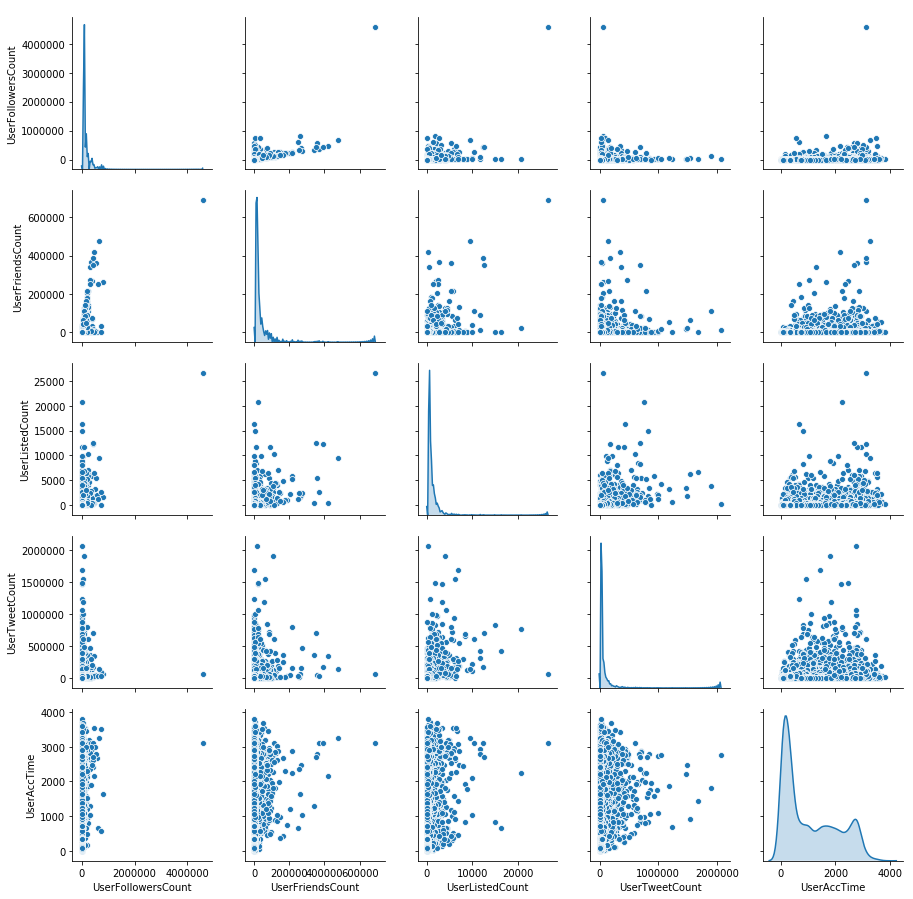

In [79]:
plt.figure(figsize=(15,12))
sns.pairplot(user_numeric_df, diag_kind='kde')
plt.show()

Such skewed distribution violates assumptions of most linear models. We might need some quantile normalisation later. Also, not too much multicollinearity that we need to worry about.

It's worth noting that some user have more than 4m followers and some user have more than 2m tweets

In [22]:
most_follower =  raw.loc[raw['UserFollowersCount']>500000, 'UserName'].value_counts()
print('These are accounts with more than 500k followers and their respective number of tweets')
print(most_follower)

These are accounts with more than 500k followers and their respective number of tweets
Lonely Planet           5
A Luxury Travel Blog    5
Social Start Now        2
Day Traders             2
Maybelline New York     1
Ammar Mohammed 🖥        1
Ted Nguyen              1
ZumaFunder GetFunded    1
Cool Mom Picks          1
Name: UserName, dtype: int64


Lonely planet has the most number of followers at around 4 million, which is significantly more than the closest one at nearly 700k - A Luxury Travel Blog. Plus, they only have 5 posts. Therefore, we can drop tweets fromm this account to prevent adding noise to the model.

In [0]:
raw = raw[raw.UserName != 'Lonely Planet']

Intuitively, user description is unlikely to correlate with the number of retweets the user get. Moreover, the processing effort is more than the tweet body due to personalisation (emoji, links, texts as hashtags,etc.). Therefore we can drop this variable.  

<h2>Tweets</h2>

In [24]:
tweet_col = ['TweetPostedTime', 'TweetBody', 'TweetRetweetFlag', 'TweetSource', 'TweetRetweetCount', 'TweetFavoritesCount',
            'TweetHashtags']
tweets = raw.loc[:,tweet_col]
tweets.head()

,TweetPostedTime,TweetBody,TweetRetweetFlag,TweetSource,TweetRetweetCount,TweetFavoritesCount,TweetHashtags
TweetID,,,,,,,
811163485052817408,2016-12-20 10:57:00+00:00,RT @BeachyMaldives: Local interaction is a great way to gain insight into the Maldivian way of life. #Maldives #vacation #travel https://t.…,True,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,0,"Maldives, vacation, travel"
811163483463122944,2016-12-20 10:56:59+00:00,RT @TechTerraEd: Need #giftideas for your kid(s)? Read our Top 25 #holiday Gift Picks List. Share &amp; email us for a chance to win one! https…,True,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,0,"giftideas, holiday"
811163466387988480,2016-12-20 10:56:55+00:00,Seven Questions Before Choosing a Cruise Line #travel #TTOT https://t.co/0geOo7v5A4,False,"<a href=""http://www.google.com/"" rel=""nofollow"">Google</a>",0,0,"travel, TTOT"
811163465125679104,2016-12-20 10:56:55+00:00,"RT @CMGsportsclub: Yoga do Brasil, un havre de paix à l’autre bout du monde https://t.co/h6UNf2tTsa #yoga #bresil #meditation #holiday",True,"<a href=""https://roundteam.co"" rel=""nofollow"">RoundTeam</a>",1,0,"yoga, bresil, meditation, holiday"
811163457508642817,2016-12-20 10:56:53+00:00,"RT @StylishRentals: Love this! ""Palm Springs Mid century Modern - Houses for Rent in Palm Springs"" @airbnb #Travel https://t.co/rzP2YB9k7t",True,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",3065,0,Travel


In [25]:
print('Our tweets starts from {} until {}'.format(min(tweets.TweetPostedTime), max(tweets.TweetPostedTime)))

Our tweets starts from 2016-12-20 00:25:12+00:00 until 2016-12-20 10:57:00+00:00


<p>A few problems we need to take care of before further analysis:</p>

<ul>
	<li>Time variables can be transformed to&nbsp;more useful ones: time of day (categories)</li>
	<li>Tags are repeated in the tweet body, removal needed</li>
	<li>Duplicate information between body and Retweetflag: &#39;RT @....&#39; can be removed&nbsp;</li>
	<li>Links in Tweet body can be removed</li>
	<li>Tweets and tags are multilingual: cannot use normal tokenization later; consider custom embedding model</li>
</ul>


In [0]:
from bs4 import BeautifulSoup as BSHTML
for idx, contents in tweets.TweetSource.iteritems():
    tweets.loc[idx,'TweetSrcProcessed']=BSHTML(contents, 'html.parser').get_text()

tweets.drop('TweetSource',axis=1,inplace = True)
tweets.TweetSrcProcessed = tweets.TweetSrcProcessed.astype('category')

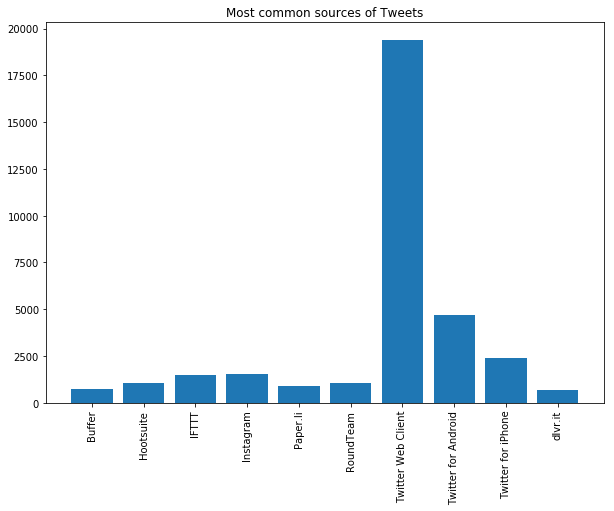

In [27]:
tweet_sources= tweets.TweetSrcProcessed.value_counts()[:10]
plt.figure(figsize=(10,7))
plt.bar(tweet_sources.index, tweet_sources, tick_label=tweet_sources.index, )
plt.xticks( rotation=90)
plt.title('Most common sources of Tweets')
plt.show()

Nearly 50% of the tweets com from Tweeter web client(could include both desktop and mobile browser), followed by Android and Iphone users. 

The hour the tweet was posted might affect the number of retweets (golden social media hour). 
The recency of the tweet will also affect its number of retweet: older tweets get more retweets. 

In [0]:
tweets['TweetHour'] = tweets.TweetPostedTime.dt.hour
tweets['TweetRecency'] = ((max(tweets.TweetPostedTime) - tweets.TweetPostedTime).dt.seconds)/60

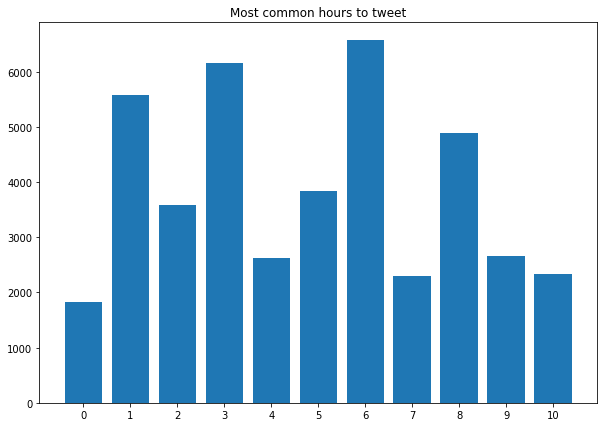

In [29]:
tweet_hours = tweets.TweetHour.value_counts()
plt.figure(figsize=(10,7))
plt.bar(tweet_hours.index, tweet_hours, tick_label = tweet_hours.index)
plt.title('Most common hours to tweet')
plt.show()

There are spikes in number of tweets at the hour of 1,3,6 and 8. Let's see if they correlate with retweets

In [0]:
import re 
pattern = r'(RT @[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)'

for idx, contents in tweets.TweetBody.iteritems():
    tweets.loc[idx, 'TweetProcessed'] = ' '.join(re.sub(pattern, ' ', contents).split())
    tweets.loc[idx, 'TweetLength'] = len(tweets.loc[idx, 'TweetProcessed'])

tweets.drop(['TweetBody'],axis=1,inplace=True)

In [31]:
tweets_numeric = tweets[['TweetHour', 'TweetRetweetCount', 'TweetFavoritesCount', 'TweetLength', 'TweetRecency']]
tweets_numeric.describe()

,TweetHour,TweetRetweetCount,TweetFavoritesCount,TweetLength,TweetRecency
count,42363.000000,42363.000000,42363.000000,42363.000000,42363.000000
mean,4.788589,1081.219862,0.799094,82.052310,344.846897
std,2.886857,1432.512271,37.208605,18.749199,175.172336
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,71.000000,197.866667
50%,5.000000,14.000000,0.000000,85.000000,346.966667
75%,7.000000,3069.000000,0.000000,91.000000,486.883333
max,10.000000,4056.000000,2813.000000,141.000000,631.800000


In [32]:
print('Number of retweets count and how common they are.')
tweets_numeric.TweetRetweetCount.value_counts().sort_values()[-10:]

Number of retweets count and how common they are.


3069    1066 
3228    1133 
3309    1158 
3180    1168 
2       1267 
1536    1536 
1       2801 
3086    3072 
3241    3232 
0       13775
Name: TweetRetweetCount, dtype: int64

A significant portion of tweets has no retweets. This would affect the model as lack of diverse data will lead to poor generalisability

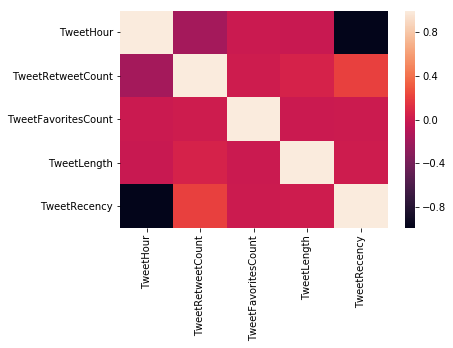

In [33]:
sns.heatmap(tweets_numeric.corr())
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


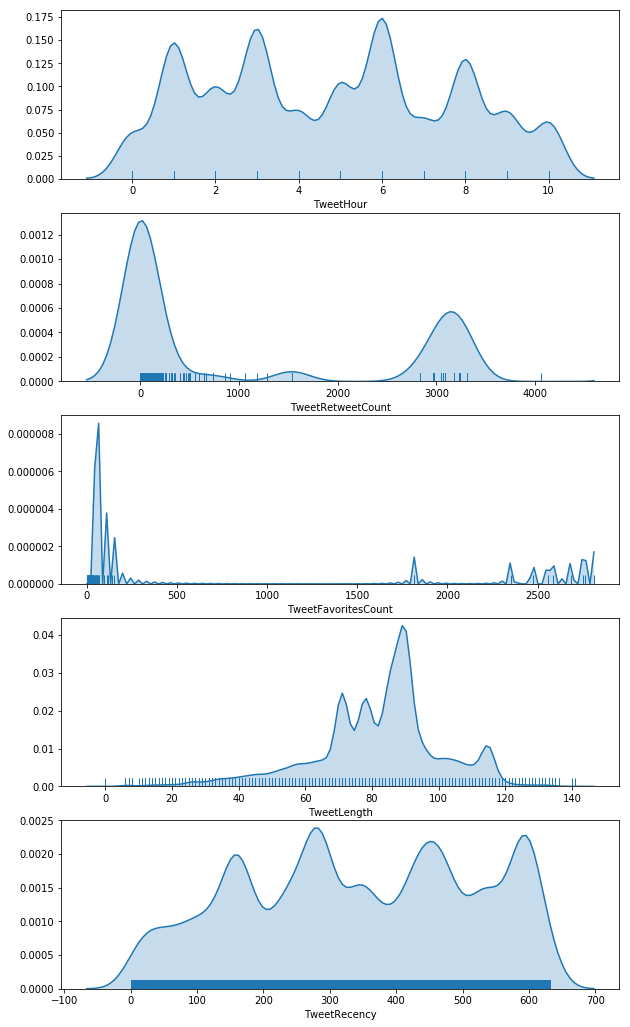

In [78]:
fig, axes = plt.subplots(len(tweets_numeric.columns),1,figsize=(10,18))


for i,col in enumerate(tweets_numeric.columns):
  sns.distplot(tweets_numeric[col], rug=True, hist=False, kde_kws={'shade':True}, ax = axes[i])

  
plt.show()

<p>Looks like there is <strong>weak</strong><strong> link</strong> between hour of the tweet; tweet favorites count and number of retweets. Also the retweet count is not normally distributed (2 peaks). Also majority of tweets receive no retweets and/or no likes. A correlation matrix confirms this:</p>


Next, let's look at the tweet contents and tags:

In [35]:
tweets.TweetProcessed.value_counts()[:10]

Vacation rental Condo in Mission Beach San Diego CA USA travel via vrbo                                                3232
Nice vacation rental Condo I found in Mission Beach San Diego CA USA travel via vrbo https                             3072
Vatican Rome Travel NikonCanada Vatican City Reflexion Nikon D3s Nikon 28 300mm Store                                  1535
Love this Hand crafted Gypsy Wagon with heart Campers RVs for Rent in Seattle airbnb Travel                            1168
Love this Chalet de Celeste Chalets for Rent in South Lake Tahoe airbnb Travel                                         1158
Cozy San Diego Beach Condo Steps 2 Beach Condominiums for Rent in San Diego airbnb Travel                              1133
The Guest Room amp The Owl House Bed amp Breakfasts for Rent in Hightown airbnb Travel                                 1105
Love this Palm Springs Mid century Modern Houses for Rent in Palm Springs airbnb Travel                                1091
Beautifu

In [36]:
tweets['TweetHashtags'].value_counts()[:10]

travel                                                  7880
Travel                                                  7793
Israel, Jerusalem, travel, travelpics, travelblogger    1586
Vatican, Rome, Travel, NikonCanada, Store               1535
travel, traveller                                       622 
Japan, Japantravel, travel                              568 
holiday                                                 450 
travel, packages, flights, Vietnam                      357 
travel, tourism, vacation                               307 
travel, ttot                                            182 
Name: TweetHashtags, dtype: int64

We have quite a lot repeated tweet contents. Those are mostly ads-like tweets. 
Also, a significant portion of hashtags are travel related

We might have multiple languages in tweets. langid can check that.

In [0]:
import langid

for idx, contents in tweets.TweetProcessed.iteritems():
       tweets.loc[idx,'TweetLang']=langid.classify(contents)[0]

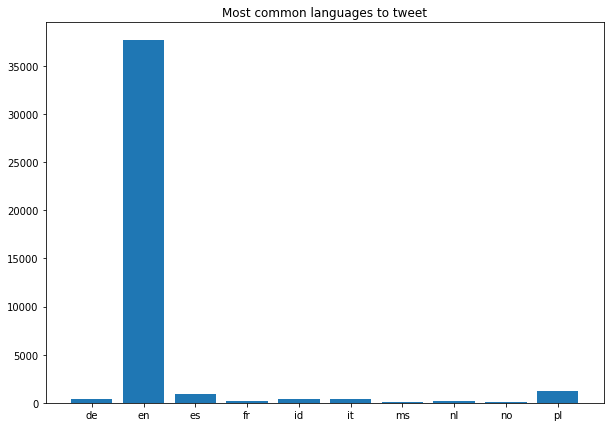

In [38]:
tweeted_lang = tweets.TweetLang.value_counts()[:10]
plt.figure(figsize=(10,7))
plt.bar(tweeted_lang.index, tweeted_lang, tick_label = tweeted_lang.index)
plt.title('Most common languages to tweet')
plt.show()

<p>Since the majority of text/document embedding are in English, we should consider dropping tweets in other language for the time being. Although should the proportion be different (more multilingual tweets), we can use FB&#39;s MUSE library for multilingual text embeddings:&nbsp;<a href="https://github.com/facebookresearch/MUSE" target="_blank">https://github.com/facebookresearch/MUSE</a></p>

<p>Next, for some standard text processing, we will need to:</p>

<ul>
	<li>remove punctuations</li>
	<li>remove spaces at beginning and ending</li>
	<li>remove tabs&nbsp;</li>
	<li>remove filler words&nbsp;</li>
	<li>lower case all words</li>
	<li>return lemma of each word</li>
</ul>


Remember there are around 5k tweets without hashtags. One can either drop those rows, embed hashtags and add to our feature space OR drop the hashtags. For the moment, let's drop hashtags to preserve our observations.    

<h2>Missing data</h2>

Some columns have high level of missing data. Let's see if there is pattern to missing data

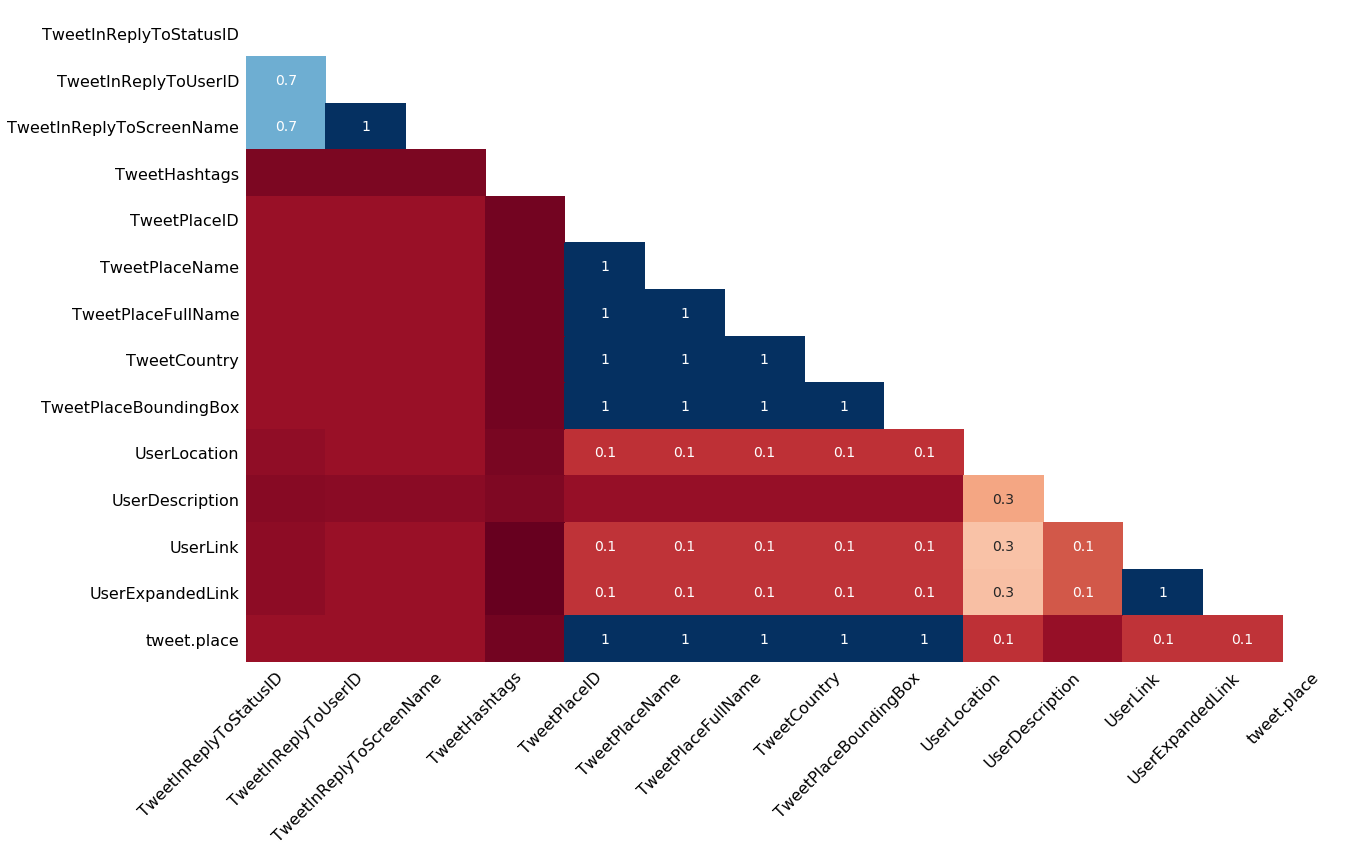

In [44]:
import missingno as msno
msno.heatmap(raw)
plt.show()

Looking at the above plot, the following can be concluded:

<ul> 
<li>It's understandable that the place related variables are missing together.</li>
<li>in_reply_to variables are missing together. </li>
<li>UserLink and UserExpandedLink are missing together</li>
</ul>

Other than that, there is no pattern to missing data. With more than 60-90% of missing data, it is advisable we drop these columns. 

Also UserScreenName is basically equivalent to UserName in sense of uniqueness, it would come handy to group tweet by users so we can drop one of them. 

<h3 id="In-summary,-the-following-changes-need-to-be-made-to-the-dataset: ">In summary, the following changes have been made to the dataset:&nbsp;</h3>

<p><strong>Adding columns:&nbsp;</strong></p>

<ul>
	<li>User:&nbsp;
	<ul>
		<li>Days since signup : = latest time captured - user signup date
		<ul>
			<li>raw[&#39;UserAccTime&#39;] = (max(raw.TweetPostedTime) - raw.UserSignupDate).dt.days</li>
		</ul>
		</li>
	</ul>
	</li>
	<li>Tweets:&nbsp;
	<ul>
		<li>Tweet Source Processed (string,cat): remove html tag</li>
		<li>TweetLength (integer): Measuring length (num character) of Tweet Processed&nbsp;</li>
		<li>TweetLang (string/cat): used to select only english tweets</li>
    <li>TweetRecency: Minutes since tweet has been posted (against latest time)</li>
		<li>TweetHour (integer): hour the tweet was posted&nbsp;</li>
		<li>Tweet Vectors: 300 dimensions embedding of processed tweet body (lemmatised, no punctuations, no stop words)&nbsp;</li>
	</ul>
	</li>
</ul>

<p><strong>Dropping columns:&nbsp;</strong></p>

<ul>
	<li>No more use: TweetBody, TweetPostedTime, TweetLang,UserName, UserID, UserDescription, TweetHashTag (also because of missing value)</li>
	<li>Missing value:&nbsp;&#39;TweetPlaceID&#39;, &#39;TweetPlaceName&#39;, &#39;TweetPlaceFullName&#39;,&#39;TweetCountry&#39;,&#39;&#39;TweetPlaceAttributes&#39;, &#39;TweetPlaceContainedWithin&#39;, &#39;tweet.place&#39;,&#39;TweetInReplyToStatusID&#39;, &#39;TweetInReplyToUserID&#39;, &#39;TweetInReplyToScreenName&#39;, &#39;UserLink&#39;, &#39;UserExpandedLink&#39;, &#39;UserLocation&#39;</li>
</ul>

<p><strong>Dropping rows:&nbsp;</strong></p>

<ul>
	<li>All rows related to Lonely Planet (outlier):&nbsp;raw = raw[raw.UserName != &#39;Lonely Planet&#39;]</li>
	<li>All rows that is not English</li>
</ul>
